CLUSTER INTERNAL VALIDATION/ RANKING

In [26]:
""" Read imputed data, clustering result (based on biomarker and clustering algorithm)
    Calculate indices using internal_validation library
    Rank the indices/ calculate the sum of each index and sort by sum in descending order
    Export result to csv/ xlsx files for each biomarker and clustering algorithm
    
    Python 3.10
    
    Last modified 3/9/2024 by Thanh Son Do
"""

import os
import new_internal_validation
from sklearn.metrics import silhouette_score, calinski_harabasz_score as ch, davies_bouldin_score as db
import pandas as pd
import numpy as np
import re
import openpyxl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [27]:
biomarkers = ['GFAP', 'NFL', 'Tau', 'UCH-L1', 'S100B', 'NSE']
algs = {'km':'kmeans', 'ga':'gaussian_mixture', 'sp':'spectral', 'sk' : 'skm', 'ag' : 'agglomerative'}
sample_threshold = 4
rank_limit = 5
weights = {
    'Sil' : 1.0,
    'Db'  : -1.0,
    # 'Db1' : -1.0,
    'Xb'  : -1.0,
    'Dunn': 0.0,
    'CH'  : 1.0,
    # 'CH1' : 1.0,
    'I'   : 0.0,
    'SD'  : 0.0,
    'S_Dbw': 0.0,
    'CVNN': 1.0,
    'MIA' : -1.0,
    'SMI' : -1.0,
    #'DB_new' : -1.0
}

'''File path to the files'''

root_path = "../../"
# sample ='462_X6'
dataFolder =  root_path + "data_preparation/biomarkers_acute_sample_462/"
# imputed data file name = biomarker + dataFile
dataFile = 'master_acute_sample_462_X7_helsinki.xlsx'

resultFolder = root_path + 'results_462_5-5_helsinki/'
# specify the location of clustering results csv files
labelFolder = resultFolder + 'cluster/'
# output file prefix:
fname = 'acute_sample462_X7_'
# This is the location of the output of the raw cluster validation result
internalFolder = resultFolder + 'validation/'
# This is the location of the output of the raw cluster validation ranked result
rankFolder = resultFolder + 'ranking/'

compPath = resultFolder + 'comp/'

os.makedirs(internalFolder, exist_ok=True)
os.makedirs(rankFolder, exist_ok=True)
os.makedirs(compPath, exist_ok=True)

xl_fname_suffix = '_1.xlsx'
plot_file_suffix = '_orig.png'  #'_imputed.png'    '_orig.png'


rawdataFolder = root_path + 'data/'
rawFile = '(to share) 6h biomarker classes, outcome 12-4-2020.xlsx'
rawSheet = '6mon'

In [28]:
def sort_files(f):
    """Sorting file name according to _k# from k2 -> k10

    Args:
        f (file name): file name

    Returns:
        k number: sorting 
    """
    match = re.search(r'_k(\d+)', f)
    if match:
        return int(match.group(1))
    else:
        return float('inf')

In [29]:
""" Get algorithm abbreviation (km, ga, sp) based on file name
"""
def get_algorithm(fname):
    for key, value in algs.items():
        if value in fname:
            return key
    return 'X'

GROUP CLUSTERING RESULT PER BIOMARKER

In [30]:
def clustering_result(biomarker):
    """Read all csv file at labelFolder directory, filtered by biomarker
        Each csv file, get the last column (cluster result) to a data frame
        order the column in ascending order of k: k2, k3, k4...
        the retrun data frame contains all cluster result from a biomarker, including all algorithm and kX
    Args:
        biomarker (input): biomarker type

    Returns:
        data frame: data frame with column name = algorith abbreviation + _kX
    """
    # select file based on biomarker, clustering algorthm
    # take file list in that folder
    df = pd.DataFrame()
    files = os.listdir(labelFolder + biomarker)
    groups = {}
    for csv in files:
        if csv.endswith('.csv'):
            # split file name and get the sub string before _kX.csv
            bio_alg = csv.rsplit('_k', 1)[0]
            # groups file name accroding the name (biomarker + algorithm like GFAP_kmeans)
            groups.setdefault(bio_alg, []).append(csv)
    # sorting file name in ascending order of number of clusters
    for bio_alg in groups:
        groups[bio_alg] = sorted(groups[bio_alg], key=sort_files)
      
    # read each files in group above, add to the same df of each group
    # then write the data to combined csv file
    for bio_alg, csv_list in groups.items():
        for f in csv_list:
            d_f = pd.read_csv(labelFolder + biomarker + '/' + f, header = 0)
            alg = get_algorithm(fname=f)
            if alg == 'X':
                continue        
            # extract cluster number from file name (k2, k3,...)
            col_name = alg + '_' + f.rsplit('_',1)[-1].split('.')[0]
            df[col_name] = d_f[d_f.columns[-1]]
    return df

CALCULATE INDICES

In [31]:
def validation_index(data, cluster_df):
    """ modified from old code - step2_metric_validation.py
        Calculate internal validation indices using internal_validation custom library
        Apply filter: only select the cluster result that has minumum number of sample exceeded the sample threshold
    Args:
        data (data frame): input data (imputed)
        cluster_df (data frame): cluster result (from cluster_result)

    Returns:
        result array: 2 dimensional array: row[0] = algorithm + kX, rows = internal validation index values
        indices_order: order of indices from row 1 to last row
    """
    scatL = []
    distL = []
    numC = []
    comL = []
    sepL = []
    result_over_k = []

    df = cluster_df.apply(pd.to_numeric, errors='coerce')
    label = df.to_numpy()        
    label = label.T
    # Indices calculation using internal_validation
    # iterate through rows of label (column of original label)
    for d_column in label:
        # num_k = list of unique value of d_colum = list of cluster number
        num_k, counts = np.unique(d_column, return_counts=True)
        # ignore if cluster sample < sample threshold
        if np.min(counts) < sample_threshold:
            continue
        #---<>---------
        inter_index = new_internal_validation.internalIndex(data, d_column)
        #----<>----------
        scat, dis, nc = inter_index.SD_valid()
        com, sep = inter_index.CVNN()
        scatL.append(scat)
        distL.append(dis)
        numC.append(nc)
        comL.append(com)
        sepL.append(sep)
   # print('SCATL', scatL)
    # print('DISL', distL)
    i = 0
    for ii, d_column in enumerate(label):
        num_k, counts = np.unique(d_column, return_counts=True)
        # ignore if cluster sample < sample threshold
        if np.min(counts) < sample_threshold:
            continue
        num_k_txt = cluster_df.columns[ii]
        result = [num_k_txt,]
        # ------<>------
        inter_index = new_internal_validation.internalIndex(data, d_column)
        # ------<>------
        result.append(silhouette_score(data, d_column, metric = 'euclidean'))
        result.append(inter_index.dbi())
        # result.append(db(data, d_column))
        result.append(inter_index.xie_benie())
        result.append(inter_index.dunn())
        result.append(inter_index.CH())
        # result.append(ch(data, d_column))
        result.append(inter_index.I())
        result.append(inter_index.SD_valid_n(scatL, distL,numC, i))
        result.append(inter_index.SDbw())
        result.append(inter_index.CVNN_n(comL, sepL, i))
        result.append(inter_index.mia())
        result.append(inter_index.smi())        
        # result.append(inter_index.new_dbi())    
        result_over_k.append(result)
        i += 1
    indices_order = ['Sil', 'Db', 'Xb', 'Dunn', 'CH', "I", "SD", "S_Dbw", "CVNN", 'MIA', 'SMI']
    # indices_order = ['Sil', 'Db', 'Db1', 'Xb', 'Dunn', 'CH', 'CH1', "I", "SD", "S_Dbw", "CVNN", 'MIA', 'SMI']
    return result_over_k, indices_order


RANK

In [32]:
def rank(df_validation):
    """Apply weights for indices
        calculates the rank of each indices, the rank is in ascending order: the higher the better
        rank_limit limits the max rank, all other below will be set to 0

    Args:
        df_validation (daat frame): cluster result input data frame (calculated, converted from validaion_index return array)
        
    Returns: ranked data frame transposed with Sum column added
    """
    df = df_validation.apply(pd.to_numeric, errors='coerce')
    df = df.mul(weights, axis='index')
    #removes 0 weight rows
    non_zeros = (df != 0).any(axis=1)
    df_rank = df[non_zeros].rank(axis='columns', method='max', ascending=True)
    if df_rank.shape[1] > rank_limit:
        df_rank -= df_rank.shape[1] - rank_limit
    df_rank[df_rank < 0] = 0
    sum_df = df_rank.sum(axis='index').to_frame().T
    sum_df.index = ['Sum']
    df_all = pd.concat([df_rank, sum_df])
    return(df_all)

MAIN PROGRAM

In [33]:
# Go through each biomarker data
# calclate indices, rank then sort by the sum
final_rank = {}
final_validation = {}
for biomarker in biomarkers:
    # read imputed data files for each biomarker
    # df = pd.read_csv(dataFolder + biomarker + dataFile, header=0)
    dfread = pd.read_excel(dataFolder + dataFile, sheet_name=biomarker + ' KNN imputed', header=0)
    df = dfread.iloc[:, -5:]
    df = df.apply(pd.to_numeric, errors='coerce')

    data = df.to_numpy()
    cluster_df = clustering_result(biomarker=biomarker)
    result_over_k, indices = validation_index(data=data, cluster_df=cluster_df)
    # export result to data frame
    to_export = np.array(result_over_k).T
    #convert to_export array to data frame, using the first row as columns
    validation_df = pd.DataFrame(to_export[1:], columns=to_export[0])
    # set validation data frame's index
    validation_df['index'] = indices
    validation_df.set_index(keys='index', drop=True, inplace=True)
    # write internal validation indices data frame to final_validation
    final_validation[biomarker] = validation_df.copy()
    # ranking validation indices
    rank_val_df = rank(validation_df).T
    # sort the ranking in descending order then write to csv file
    sort_rank_df = rank_val_df.sort_values(by=rank_val_df.columns[-1], ascending=False)
    #sort_rank_df.to_csv(rankFolder + biomarker + '_rank_442.csv', header=True, index=True)
    final_rank[biomarker] = sort_rank_df.copy()


<Figure size 300x300 with 0 Axes>

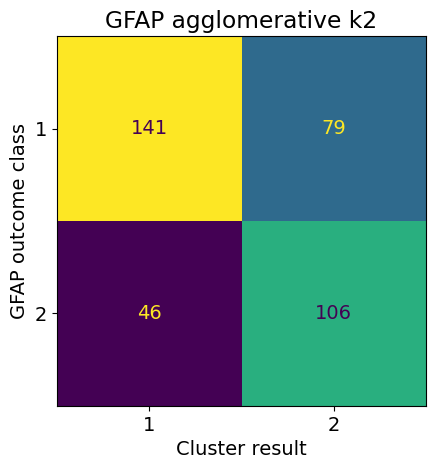

<Figure size 300x300 with 0 Axes>

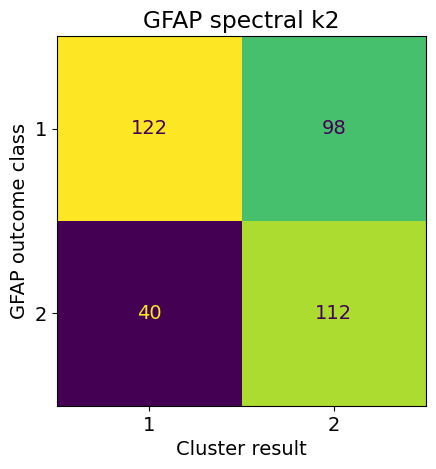

<Figure size 300x300 with 0 Axes>

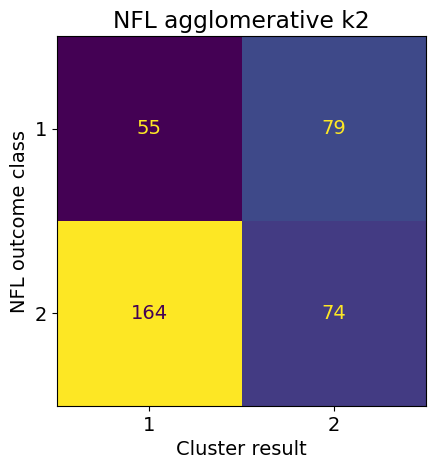

<Figure size 300x300 with 0 Axes>

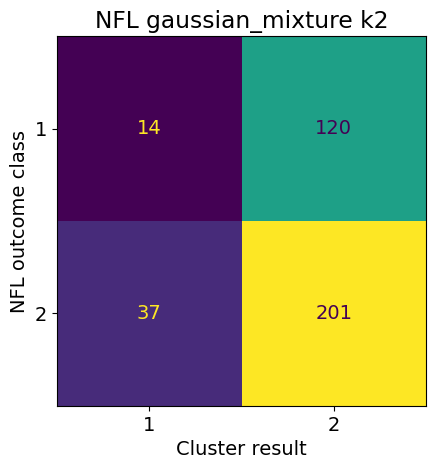

<Figure size 300x300 with 0 Axes>

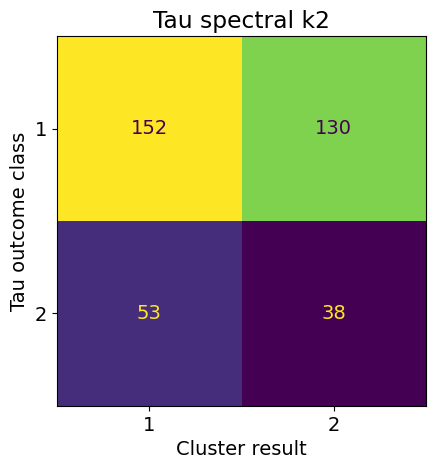

<Figure size 300x300 with 0 Axes>

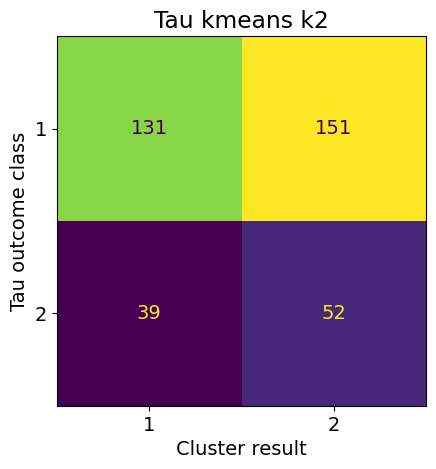

<Figure size 300x300 with 0 Axes>

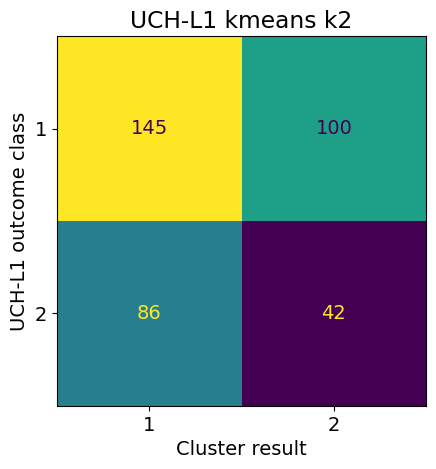

<Figure size 300x300 with 0 Axes>

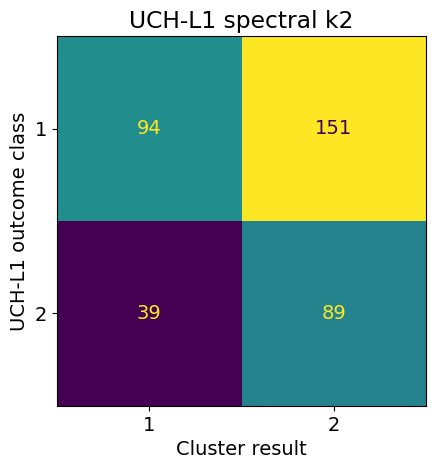

<Figure size 300x300 with 0 Axes>

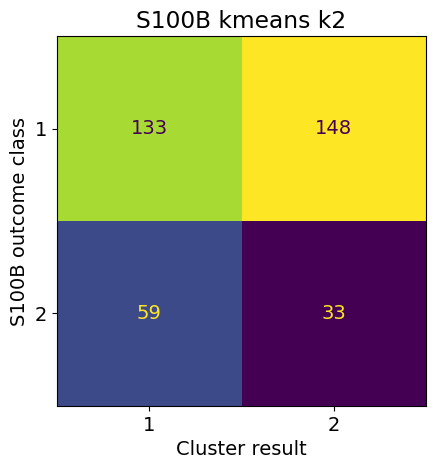

<Figure size 300x300 with 0 Axes>

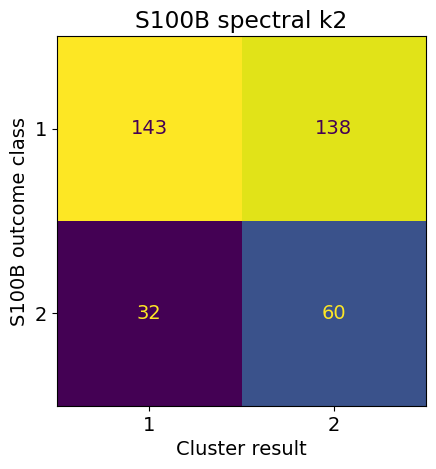

<Figure size 300x300 with 0 Axes>

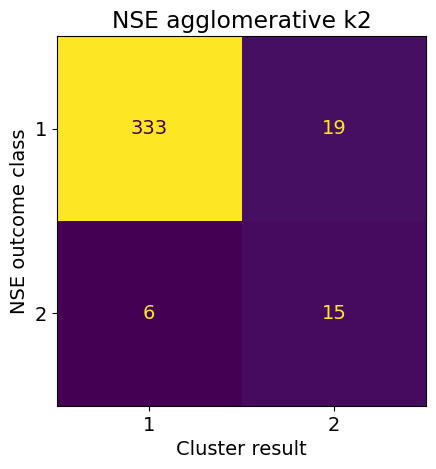

<Figure size 300x300 with 0 Axes>

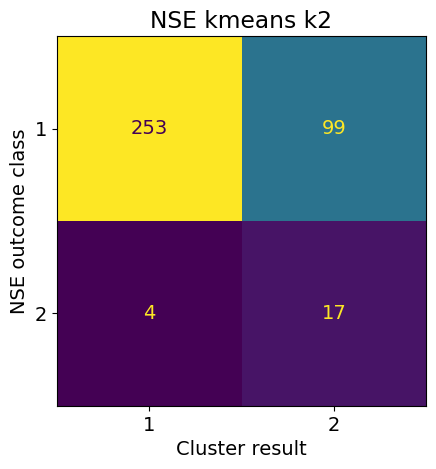

In [34]:
# Compare outcomes

dfr = pd.read_excel(rawdataFolder + rawFile, sheet_name=rawSheet, index_col=0, header=0)
dfr.index.name ='subjectId'
dfr.index = dfr.index.str.upper()
dfr.rename(columns = {'UCHL1class': 'UCH-L1class'}, inplace=True)
dfdata = pd.read_excel(dataFolder + dataFile, sheet_name='GFAP', header=0, index_col=0)

for biomarker in biomarkers:
    for ii in range(2):
        algk = final_rank[biomarker].index[ii]
        alg, kX = algk.split('_',1)[0], algk.split('_',1)[1]
        clusterFile =  biomarker + '_' + algs[alg] + '_' + kX + '.csv'
        dfc = pd.read_csv(labelFolder + biomarker + '/' + clusterFile, header = 0)
        if dfc['Cluster'].nunique() > 2:
            continue
        dfc.index = dfdata.index.str.upper()
        cluster_counts = dfc['Cluster'].value_counts()
        outcome_counts = dfr[biomarker + 'class'].value_counts()
        # print(dfc['Cluster'].dtype, dfr[biomarker + 'class'].dtype)
        # map1 = {1:2, 2:1}
        # if cluster_counts[1] > cluster_counts[2]:
        #     if outcome_counts[1] < outcome_counts[2]:
        #         dfc['Cluster'] = dfc['Cluster'].replace(map1)
        # else:
        #     if  outcome_counts[1] > outcome_counts[2]:
        #         dfc['Cluster'] = dfc['Cluster'].replace(map1)
        # cluster_counts = dfc['Cluster'].value_counts()
        # print(cluster_counts, outcome_counts, '\n----\n')        
        
        dfc[biomarker + 'class'] = dfr[biomarker + 'class']
        dfc.index = dfdata.index
        dfc.to_csv(compPath + clusterFile + '_comp.csv', header = True, index = True)
        dfcc = dfc.dropna()
        # dfc['Cluster'] = dfc['Cluster'] - 1
        # dfc[biomarker + 'class'] = dfc[biomarker + 'class'] - 1
        conf_matrix = confusion_matrix(dfcc[biomarker + 'class'], dfcc['Cluster'])
        # print(biomarker + ' ' + algs[alg] + ' ' + kX)
        # print(cluster_counts, outcome_counts)
        plt.figure(figsize=(3,3))
        font = {'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
        plt.rc('font', **font)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[1,2])
        disp.plot(colorbar=False)
        fig_name = biomarker + ' ' + algs[alg] + ' ' + kX
        disp.ax_.set(xlabel='Cluster result', ylabel=biomarker + ' outcome class', title=fig_name)
        # plt.xlabel('Cluster')
        # plt.ylabel(biomarker + ' Class')
        # plt.title(biomarker + ' Confusion Matrix')
        plt.savefig( compPath + fig_name)
        plt.show()
        

EXPORT TO EXCEL FILE

In [35]:
def get_plot_file(biomarker, algk):
    """Get plot file according to ranking

    Args:
        biomarker (biomarker): GFAP, NFL,...
        algk (algorithm + kX): km_k2, km_k5, sp_k3,...

    Returns:
        path: image file + path
        'X': if no image file found
    """
    alg, kX = algk.split('_',1)[0], algk.split('_',1)[1]
    plots_path = labelFolder + biomarker + '/' + algs[alg] + '_plots/'    
    plot_files = os.listdir(plots_path)
    plot_files = [file for file in plot_files if file.endswith(plot_file_suffix)]
    plot_file = [file for file in plot_files if kX in file]
    if len(plot_file) > 0:
        return plots_path + plot_file[0]
    return 'X'

In [37]:
# export result to excel work book
# excel file name for validation indices
xl_fname = internalFolder + fname + 'validation' + xl_fname_suffix
with pd.ExcelWriter(xl_fname) as excelW:
    for biomarker in biomarkers:
        final_validation[biomarker].to_excel(excelW, sheet_name=biomarker, index=True, header=True)

xl_fname = rankFolder + fname + 'rank' + xl_fname_suffix
with pd.ExcelWriter(xl_fname) as excelW:
    for biomarker in biomarkers:
        final_rank[biomarker].to_excel(excelW, sheet_name=biomarker, index=True, header=True)

# add image of first 2 best ranked clusters   
# continue to use xl_fname from the previous block     
xl_book = openpyxl.load_workbook(xl_fname)
for biomarker in biomarkers: 
    first_image = get_plot_file(biomarker=biomarker, algk=final_rank[biomarker].index[0])
    second_image = get_plot_file(biomarker=biomarker, algk=final_rank[biomarker].index[1])
    # image position in excel sheet
    xl_cell1 = chr(64 + final_rank[biomarker].shape[1] + 3) + '1'
    xl_cell2 = chr(64 + final_rank[biomarker].shape[1] + 3) + '27'
    # add image to each sheet per biomarker
    xl_sheet = xl_book[biomarker]
    if first_image != 'X':
        img1 = openpyxl.drawing.image.Image(first_image)
        img1.width, img1.height = 640, 480
        xl_sheet.add_image(img1, xl_cell1)
    if second_image != 'X':
        img2 = openpyxl.drawing.image.Image(second_image)
        img2.width, img2.height = 640, 480
        xl_sheet.add_image(img2, xl_cell2)
    xl_book.save(xl_fname)

============================  END =============================

In [ ]:
# Write to excel file biomarker/ sheet
# with pd.ExcelWriter(internalFolder + fname + 'validation_8i.xlsx') as excelW:
#     for biomarker in biomarkers:
#         final_validation[biomarker].to_excel(excelW, sheet_name=biomarker, index=True, header=True)
# with pd.ExcelWriter(rankFolder + fname + 'rank_8i.xlsx') as excelW:
#     for biomarker in biomarkers:
#         final_rank[biomarker].to_excel(excelW, sheet_name=biomarker, index=True, header=True)
